In [12]:
#Imports

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [15, 15]

In [13]:
#Reading Data

cmo_msp = pd.read_csv('CMO_MSP_Mandi.csv')
monthly_data = pd.read_csv('Monthly_data_cmo.csv')

print("Shape of cmo_msp is: ", cmo_msp.shape)
print("Shape of monthly data is: ", monthly_data.shape)

Shape of cmo_msp is:  (155, 5)
Shape of monthly data is:  (62429, 11)


## Displaying Data in the form of table

In [14]:
cmo_msp.head(10)

,commodity,year,Type,msprice,msp_filter
0,PADDY-UNHUSKED,2012,Kharif Crops,1250.0,1
1,RICE(PADDY-HUS),2012,Kharif Crops,1280.0,1
2,Jowar_Hybrid,2012,Kharif Crops,1500.0,1
3,SORGUM(JAWAR),2012,Kharif Crops,1520.0,1
4,BAJRI,2012,Kharif Crops,1175.0,1
5,MAIZE,2012,Kharif Crops,1175.0,1
6,Ragi_Maldandi,2012,Kharif Crops,1500.0,1
7,PIGEON PEA (TUR),2012,Kharif Crops,3850.0,1
8,SPILT GERRN GRAM,2012,Kharif Crops,4400.0,1
9,SPLIT BLACK GRAM,2012,Kharif Crops,4300.0,1


In [15]:
monthly_data.head(10)

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04,Ahmadnagar,Maharashtra
1,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,2016-04,Ahmadnagar,Maharashtra
2,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,2015-04,Ahmadnagar,Maharashtra
3,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,2016-04,Ahmadnagar,Maharashtra
4,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,2015-04,Ahmadnagar,Maharashtra
5,Ahmednagar,Sorgum(Jawar),2016,April,2093,1695,2454,2119,2016-04,Ahmadnagar,Maharashtra
6,Ahmednagar,Maize,2015,April,75,1345,1401,1373,2015-04,Ahmadnagar,Maharashtra
7,Ahmednagar,Maize,2016,April,155,1367,1392,1375,2016-04,Ahmadnagar,Maharashtra
8,Ahmednagar,Gram,2015,April,1794,3533,3762,3647,2015-04,Ahmadnagar,Maharashtra
9,Ahmednagar,Gram,2016,April,630,4790,5553,5216,2016-04,Ahmadnagar,Maharashtra


## Detecting and Removing Outliers

In [16]:
#Functions

def select_data(dataset, year, month):
    df = dataset[dataset["date"] == (year+'-'+month)]
    return df

In [17]:
#Commodity based distinction - Dataset prep

df_comm = pd.DataFrame(columns=["arrivals_in_qtl", "modal_price", "price_sensitivity", "date", "commodity"])

df_comm["arrivals_in_qtl"] = monthly_data["arrivals_in_qtl"]
df_comm["modal_price"] = monthly_data["modal_price"]
df_comm["price_sensitivity"] = monthly_data["max_price"] - monthly_data["min_price"]
df_comm["date"] = monthly_data["date"]
df_comm["commodity"] = monthly_data["Commodity"]

print("Before\n", df_comm.head(),"\n\n")

scaler = preprocessing.StandardScaler()
dataset = pd.DataFrame(data=df_comm, columns=["arrivals_in_qtl", "modal_price", "price_sensitivity"])
dataset.fillna(dataset.mean())
dataset = scaler.fit_transform(dataset)
dataset = pd.DataFrame(data=dataset, columns=["arrivals_in_qtl", "modal_price", "price_sensitivity"])

df_comm["arrivals_in_qtl"] = dataset["arrivals_in_qtl"]
df_comm["modal_price"] = dataset["modal_price"]
df_comm["price_sensitivity"] = dataset["price_sensitivity"]

print("After\n",df_comm.head(),"\n\n")

Before
    arrivals_in_qtl  modal_price  price_sensitivity     date      commodity
0               79         1463                132  2015-04          Bajri
1              106         1875                137  2016-04          Bajri
2             1253         1731                318  2015-04  Wheat(Husked)
3              387         1999                470  2016-04  Wheat(Husked)
4             3825         1900                600  2015-04  Sorgum(Jawar) 


After
    arrivals_in_qtl  modal_price  price_sensitivity     date      commodity
0        -0.171861    -0.508072          -0.042321  2015-04          Bajri
1        -0.171083    -0.393874          -0.041975  2016-04          Bajri
2        -0.138031    -0.433788          -0.029450  2015-04  Wheat(Husked)
3        -0.162985    -0.359504          -0.018932  2016-04  Wheat(Husked)
4        -0.063916    -0.386944          -0.009936  2015-04  Sorgum(Jawar) 




To help visualise this, we use PCA to reduce the dimensionality of the problem: 




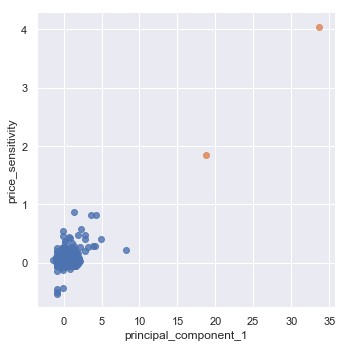

In [18]:
#Use the select data to detect outliers on a seasonal basis
comm_data = select_data(df_comm,"2015","05")
train, cv, test = comm_data[:50000], comm_data[50000:56000], comm_data[56000:62429]

pca = PCA(n_components=1)
principalComponents = pca.fit_transform(pd.DataFrame(data=[train["arrivals_in_qtl"],train["modal_price"]]).T)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal_component_1'])
principalDf["price_sensitivity"] = np.array(train["price_sensitivity"])

#Using K-Means Clustering to determine Outliers
kmeans = KMeans(n_clusters=2,random_state=0).fit_predict(principalDf)
principalDf["class"] = kmeans

print("To help visualise this, we use PCA to reduce the dimensionality of the problem: \n\n")
sns.lmplot( x="principal_component_1", y="price_sensitivity", data=principalDf, fit_reg=False, hue='class', legend=False)
plt.show()

In [19]:
#Removing Outliers
df_data = pd.DataFrame(columns = df_comm.columns)

for year in ["2014","2015","2016"]:
    for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
        comm_data = select_data(df_comm,year,month)
        if(comm_data.shape[0]):
            pca = PCA(n_components=1)
            principalComponents = pca.fit_transform(pd.DataFrame(data=[comm_data["arrivals_in_qtl"],comm_data["modal_price"]]).T)
            principalDf = pd.DataFrame(data = principalComponents,
                                       columns = ['principal_component_1'])
            principalDf["price_sensitivity"] = np.array(comm_data["price_sensitivity"])
            kmeans = KMeans(n_clusters=2,random_state=0).fit_predict(principalDf)
            principalDf["class"] = kmeans
            df_data = pd.concat([df_data, comm_data[list(principalDf["class"] == 0)]])        
            
df_data = df_data.merge(monthly_data,how="inner",left_index=True,right_index=True)
del df_data["arrivals_in_qtl_x"]
del df_data["modal_price_x"]
del df_data["date_x"]
del df_data["price_sensitivity"]
del df_data["commodity"]
df_data.head()      
df_data.columns = ['APMC', 'Commodity', 'Year', 'Month', 'arrivals_in_qtl', 'min_price',
       'max_price', 'modal_price', 'date', 'district_name', 'state_name']
df_data.to_csv("outliers_removed.csv")

## Seasonality of cluster based on APMC and Commodity

In [20]:
#Functions

def get_data(dataset,apmc, comm):
    return dataset[(df_data["APMC"] == apmc) & (df_data["Commodity"] == comm)]

In [21]:
#As we need to study price fluctuation we will need to use (max_price - min_price)
new_df = pd.DataFrame()
new_df["price_fluctuation"] = df_data["max_price"] - df_data["min_price"]
new_df["date"] = [datetime.date(*(int(x) for x in (s + '-15').split('-'))) for s in df_data["date"]]
new_df["APMC"] = df_data["APMC"]
new_df["Commodity"] = df_data["Commodity"]
# Use get_data(new_df, "Ahmednagar", "Bajri") to get the data of "Ahmednagar" and "Bajri" cluster

Initial data trends and graphs: 


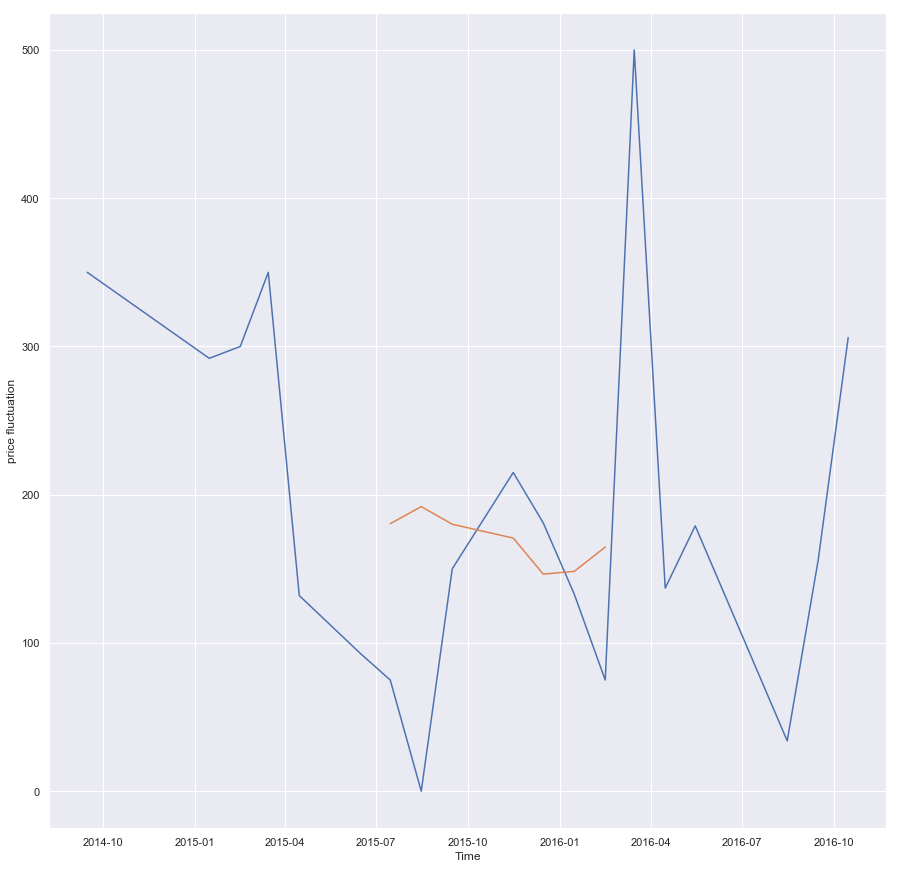

Fitting a smooth curve, we get: 


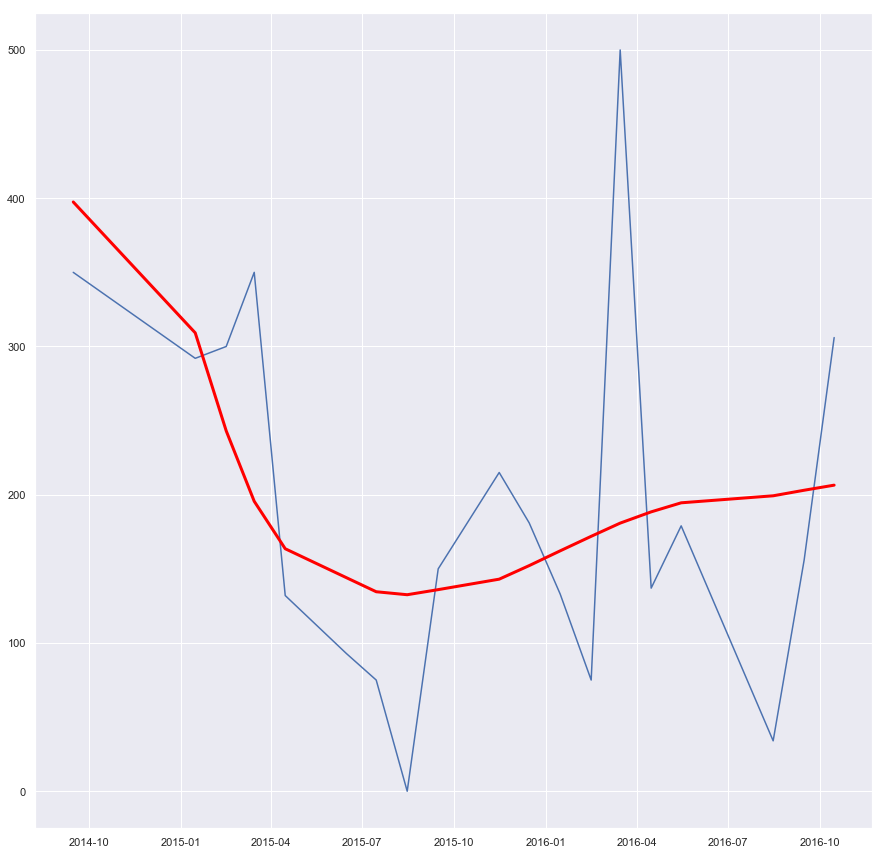

Deseasonalised Output is: 


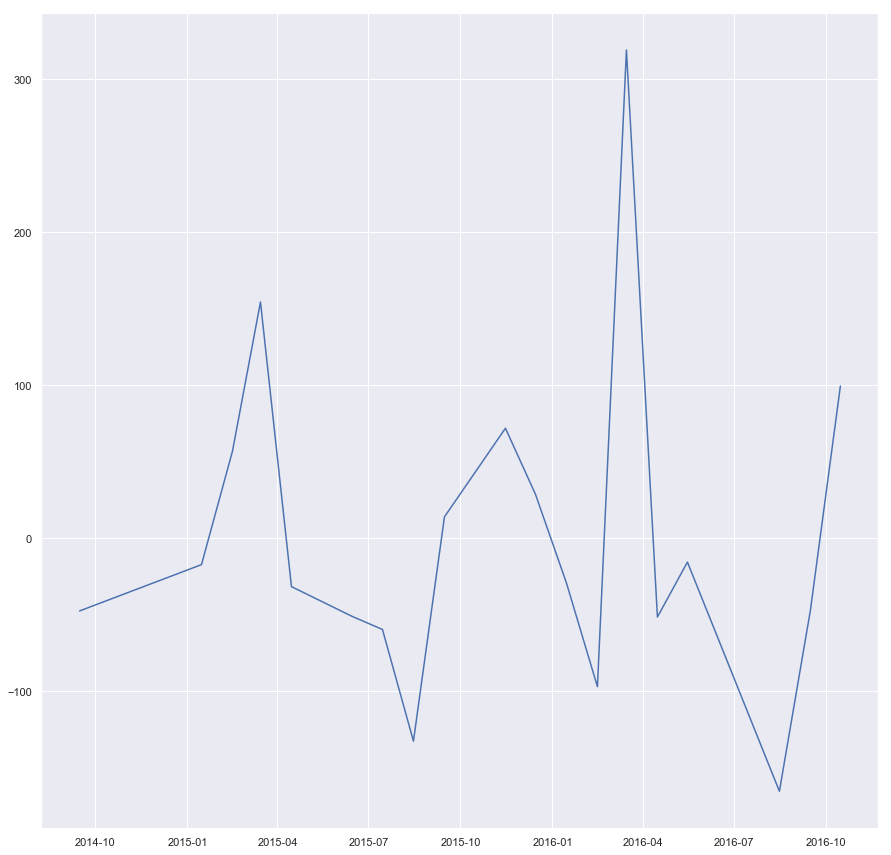

In [22]:
#Using inbulit functions and methodically selecting data according to APMC and Commodity
#This example is using additive seasonality as can be observed from the shape of the graph which is not exponentially
#or falling

print("Initial data trends and graphs: ")
series = get_data(new_df,"Ahmednagar","Bajri")
series = series.set_index("date").sort_values(by="date")
plt.plot(series.index,series["price_fluctuation"],label="Observations")
plt.xlabel("Time")
plt.ylabel("price fluctuation")
s=sm.tsa.seasonal_decompose(series["price_fluctuation"], model="additive", freq = 13)
plt.plot(s.trend)
plt.plot(s.seasonal)
plt.show()

#To deseasonlise, we try and fit the data to a polynomial which can be accordingly modelled.

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series.index))]
y = series.price_fluctuation
degree = 4
coef = np.polyfit(X, y, degree)

# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
curve = pd.DataFrame(data = curve,index= series.index, columns=["price_fluctation"])    

print("Fitting a smooth curve, we get: ")
# plot curve over original data
plt.plot(series.price_fluctuation)
plt.plot(curve, color='red', linewidth=3)
plt.show()

#As we can see, the curve makes a good approximation of data. Now to deseaonalise, we can simply
#subtract the value of the curves, with the predicted value
print("Deseasonalised Output is: ")

values = series.price_fluctuation
diff = []
for i in range(len(values)):
    value = values[i] - curve.iloc[i]
    diff.append(value)
plt.plot(pd.DataFrame(diff,index = series.index))
plt.show()

## Comparing Mandi Prices and MSP Prices

In [392]:
# We need to get the data in the same dataframe, hence we can use the join function
df_data.columns = ['APMC', 'commodity', 'year', 'Month', 'arrivals_in_qtl', 'min_price',
       'max_price', 'modal_price', 'date', 'district_name', 'state_name']
#WARNING: Significant loss of data here, due to data mismatch.
df_data["commodity"] = [s.lower() for s in df_data["commodity"]]
cmo_msp["commodity"] = [s.lower() for s in cmo_msp["commodity"]]

comp_data = pd.merge(df_data, cmo_msp, on=["commodity","year"])

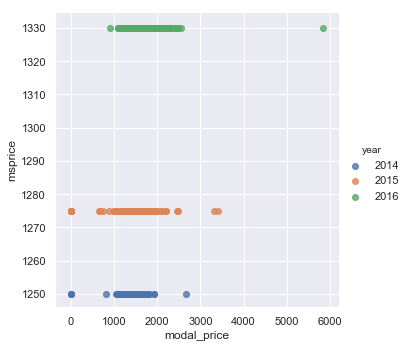

In [428]:
#Carrying over the previous data, as we will need the deseasonalised data, from the previous section, i.e.
#update the value of 'diff' for revised deseasonalised values.
def commodity_data(dataset,commodity):
    return dataset[dataset["commodity"] == commodity]

sel_data = commodity_data(comp_data,"bajri")
sns.lmplot( x="modal_price", y="msprice", data=sel_data, fit_reg=False, hue='year', legend=True)
plt.show()

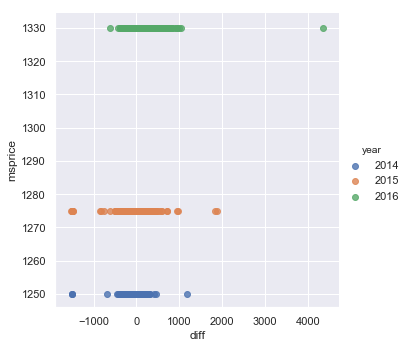

In [429]:
sel_data = commodity_data(comp_data,"bajri")
sel_data["commodity"] = [s.lower() for s in sel_data["commodity"]]

#To deseasonlise, we try and fit the data to a polynomial which can be accordingly modelled.
# fit polynomial: x^2*b1 + x*b2 + ... + bn

X = [i%365 for i in range(0, len(sel_data.index))]
y = sel_data.modal_price
degree = 4
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
curve = pd.DataFrame(data = curve,index= sel_data.index, columns=["modal_price"])    
diff = sel_data["modal_price"] - curve["modal_price"]
sel_data["diff"] = diff 
sns.lmplot( x="diff", y="msprice", data=sel_data, fit_reg=False, hue='year', legend=True)
plt.show()